<!-- ---------------------------------------------------- -->
  <div class="col-sm-3 col-md-3 col-lg-3">
	<!-- logo -->  
    <div class="img-responsive">
      <img src="https://www.dropbox.com/s/220ncn0o5danuey/pandas-ipython-tutorials-hedaro.jpg?dl=1" title="Pandas Tutorial | Hedaro" alt="Pandas Tutorial | Hedaro">    
    </div>
	<!-- logo -->	
  </div>
<!-- ---------------------------------------------------- --> 
  <div class="col-sm-6 col-md-6 col-lg-6">
	<!-- Pandas Tutorial -->  
	  <center>
	    <br>
        <h1>Data Analysis - Double Exponential Smoothing</h1>
        <p>Learn how to use Pandas and Statmodels to perform Double <strong>Exponential Smoothing</strong> on time series data</p>
	  </center>	
    <!-- Pandas Tutorial -->	
  </div>
<!-- ---------------------------------------------------- -->

In [1]:
# pandas imports
import pandas as pd
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

# statsmodels imports
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm

# matplotlib imports
import matplotlib.pyplot as plt
import matplotlib as mpl # only needed to get version
%matplotlib inline

In [2]:
print('pandas version: ' + pd.__version__)
print('pandas version: ' + sm.version.version)
print('matplotlib version: ' + mpl.__version__)

pandas version: 0.22.0
pandas version: 0.9.0rc1
matplotlib version: 1.5.1


# Resources Used

* [Statsmodels Notebook- not rendered](https://github.com/statsmodels/statsmodels/blob/master/examples/notebooks/exponential_smoothing.ipynb)

* [Statsmodels Notebook- rendered](https://github.com/tvanzyl/statsmodels/blob/881588c33899554ccd8df0da59be8cf806c8b973/examples/notebooks/exponential_smoothing.ipynb) - This notebook was the starting point for this tutorial.

* [Time Series Book](https://www.otexts.org/fpp/7) - Note that some of the text in this tutorial was copied exactly from this book. In certain sections I paraphrased the text from the book to make it easier to understand. 

# Definitions  

* The ***[SSE](https://en.wikipedia.org/wiki/Residual_sum_of_squares)*** is the sum of the squared errors  
* A ***trend*** exists when there is a long-term increase or decrease in the data.    
* A ***seasonal*** pattern occurs when a time series is affected by seasonal factors such as the time of the year or the day of the week.
* A ***cycle*** occurs when the data exhibit rises and falls that are not of a fixed period.

# Data Sets  

> These data sets come from the Time Series book in the Resources section. Note that the Statsmodels notebook is where I got the data sets from  

***important*** - Notice that the date index was given a frequency. The reason for this is that the exponential smoothing functions require your date index to have a frequency. This becomes important when you try to use your own data as frequency might not be something you normally set on your date columns.

In [3]:
data = [446.6565,  454.4733,  455.663 ,  423.6322,  456.2713,  440.5881, 425.3325,  485.1494,  506.0482,  526.792 ,  514.2689,  494.211 ]
index= pd.DatetimeIndex(start='1996', end='2008', freq='A')
oildata = pd.DataFrame(data, columns=['Sales'])
oildata.set_index(index, inplace=True)

data = [17.5534,  21.86  ,  23.8866,  26.9293,  26.8885,  28.8314, 30.0751,  30.9535,  30.1857,  31.5797,  32.5776,  33.4774, 39.0216,  41.3864,  41.5966]
index= pd.DatetimeIndex(start='1990', end='2005', freq='A')
air = pd.DataFrame(data, columns=['Sales'])
air.set_index(index, inplace=True)

data = [263.9177,  268.3072,  260.6626,  266.6394,  277.5158,  283.834 , 290.309 ,  292.4742,  300.8307,  309.2867,  318.3311,  329.3724, 338.884 ,  339.2441,  328.6006,  314.2554,  314.4597,  321.4138, 329.7893,  346.3852,  352.2979,  348.3705,  417.5629,  417.1236, 417.7495,  412.2339,  411.9468,  394.6971,  401.4993,  408.2705, 414.2428]
index= pd.DatetimeIndex(start='1970', end='2001', freq='A')
livestock2 = pd.DataFrame(data, columns=['Sales'])
livestock2.set_index(index, inplace=True)

data = [407.9979 ,  403.4608,  413.8249,  428.105 ,  445.3387,  452.9942, 455.7402]
index= pd.DatetimeIndex(start='2001', end='2008', freq='A')
livestock3 = pd.DataFrame(data, columns=['Sales'])
livestock3.set_index(index, inplace=True)

data = [41.7275,  24.0418,  32.3281,  37.3287,  46.2132,  29.3463, 36.4829,  42.9777,  48.9015,  31.1802,  37.7179,  40.4202, 51.2069,  31.8872,  40.9783,  43.7725,  55.5586,  33.8509, 42.0764,  45.6423,  59.7668,  35.1919,  44.3197,  47.9137]
index= pd.DatetimeIndex(start='2005', end='2010-Q4', freq='QS')
aust = pd.DataFrame(data, columns=['Sales'])
aust.set_index(index, inplace=True)

# Theory

### Double Exponential Smoothing
* This method is suitable for forecasting data with trend and no seasonal pattern  
<br>  
* 0 ≤ α ≤ 1  is the smoothing parameter for the level  
* The weights attached to the observations decrease exponentially as we go back in time, hence the name “exponential smoothing”
* If α is small (i.e., close to 0), more weight is given to observations from the more distant past  
* If α is large (i.e., close to 1), more weight is given to the more recent observations    
<br>  
* 0 ≤ β ≤ 1  is the smoothing parameter for the trend  

# air  

> please go to https://www.otexts.org/fpp/7/2

In [4]:
air

Sales
1990-12-31  17.5534
1991-12-31  21.8600
1992-12-31  23.8866
1993-12-31  26.9293
1994-12-31  26.8885
1995-12-31  28.8314
1996-12-31  30.0751
1997-12-31  30.9535
1998-12-31  30.1857
1999-12-31  31.5797
2000-12-31  32.5776
2001-12-31  33.4774
2002-12-31  39.0216
2003-12-31  41.3864
2004-12-31  41.5966

> ***Notice *** that there are no gaps in the data set and each data point was captured on the same day on each year. If your data set has gaps in the dates, you will need to use the Pandas resample function to fill in the gaps.

In [5]:
air.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15 entries, 1990-12-31 to 2004-12-31
Freq: A-DEC
Data columns (total 1 columns):
Sales    15 non-null float64
dtypes: float64(1)
memory usage: 240.0 bytes


The plot below clearly shows an upward trend. I am not seeing a re-occurring pattern that pertains to a specific year or calendar day/week/month. This leads me to say that our data has no seasonality.

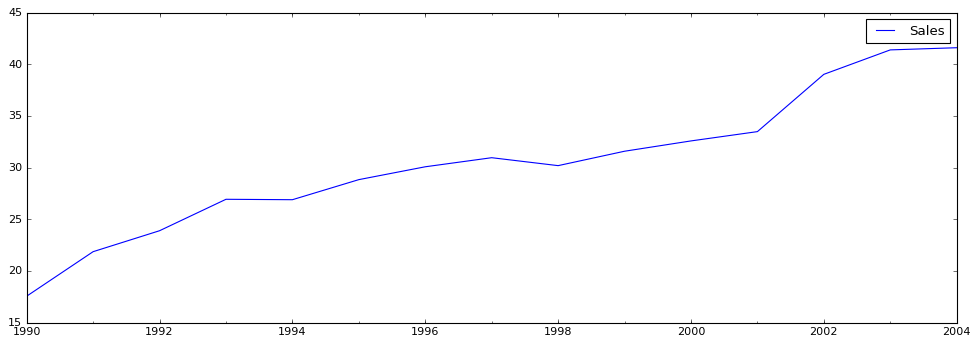

In [6]:
air.plot(figsize=(15,5));

Let's continue our Exploratory Analysis of our data. [resource](https://www.itl.nist.gov/div898/handbook/eda/section3/4plot.htm)

1. Run sequence plot (top left) to test fixed location and variation.  

2. Lag Plot (top right) to test randomness.

3. Histogram (bottom left) to test (normal) distribution.  

4. Normal probability plot (bottom right) to test normal distribution.  

Of the 4 underlying assumptions:  
* If the fixed location assumption holds, then the run sequence plot will be flat and non-drifting.
* If the fixed variation assumption holds, then the vertical spread in the run sequence plot will be approximately the same over the entire horizontal axis.
* If the randomness assumption holds, then the lag plot will be structure less and random.
* If the fixed distribution assumption holds (in particular, if the fixed normal distribution assumption holds), then the histogram will be bell-shaped and the normal probability plot will be approximately linear.  
* When the randomness assumption is thus seriously violated, the histogram (lower left) and normal probability plot (lower right) are ignored since determining the distribution of the data is only meaningful when the data are random.

***Conclusions*** - Since we are working with Time Series data, I use the run sequence to look for trends and seasonality. We already covered this from our last chart. The lag plot shows a linear pattern. Having a pattern means that our data is predictable. If our data was all random then it will not be predictable and we would not be able to use the exponential smoothing models. The histogram and the probability distribution tell me that we are not working with a normally distributed data set.

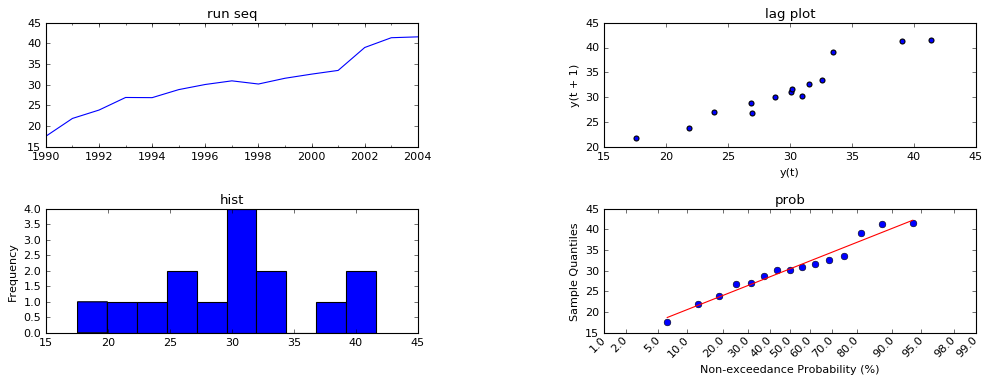

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2)
plt.subplots_adjust(wspace=0.5, hspace=0.5);

air['Sales'].plot(ax=axes[0,0], figsize=(15,5)); axes[0,0].set_title('run seq');
lag_plot(air['Sales'], ax=axes[0,1]); axes[0,1].set_title('lag plot');
air['Sales'].plot.hist(ax=axes[1,0], figsize=(15,5)); axes[1,0].set_title('hist');
sm.ProbPlot(air['Sales']).probplot(line='r',ax=axes[1,1]); axes[1,1].set_title('prob');

# Trend and Seasonality in ACF plots

When data has a trend, the autocorrelations for small lags tend to be large and positive because observations nearby in time are also nearby in size. So the ACF of trended time series tend to have positive values that slowly decrease as the lags increase.  

When data are seasonal, the autocorrelations will be larger for the seasonal lags (at multiples of the seasonal frequency) than for other lags.

When data are both trended and seasonal, you see a combination of these effects. 

For white noise series, we expect each autocorrelation to be close to zero. Of course, they will not be exactly equal to zero as there is some random variation. It is common to plot these bounds on a graph of the ACF (the gray solid lines below). If one or more large spikes are outside these bounds, or if substantially more than 5% of spikes are outside these bounds, then the series is probably not white noise.

> The horizontal lines displayed in the plot below correspond to 95% and 99% confidence bands. The dashed line is 99% confidence band.

***conclusion*** - The autocorrelation plot shows a slow decrease as the lags increase. This shows a similar pattern to the oil data which makes me rethink if out last data set did have a trend. What do you think?

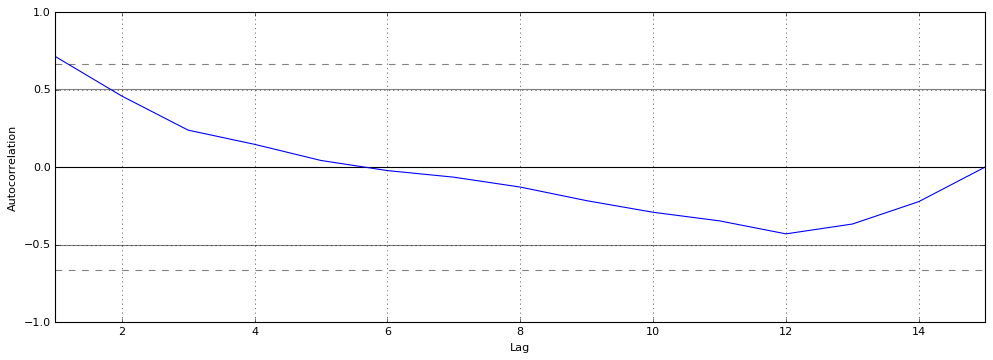

In [8]:
plt.figure(figsize=(15, 5))
autocorrelation_plot(air['Sales']);

# Here we run three variants of simple exponential smoothing:

> We want to match the results from [7.1 Simple exponential smoothing](https://www.otexts.org/fpp/7/1)

* In fit1a we do not use the auto optimization but instead choose to explicitly provide the model with the $\alpha=0.2$ parameter
* In fit1b as above we choose an $\alpha=0.6$
* In fit1c we allow statsmodels to automatically find an optimized $\alpha$ value for us. This is the recommended approach.

# Here we run several variants of double exponential smoothing:

> We want to match the results from [7.2 Holts Linear Trend Method](https://www.otexts.org/fpp/7/2)

* In fit2a we again choose not to use the optimzer and provide explicit values for $\alpha=0.8$ and $\beta=0.2$
* In fit2b we do the same as in fit2a but choose to use an exponential model rather than a Holt's additive model.
* In fit2c we used a damped versions of the Holt's additive model but allow the dampening parameter $\phi$ to be optimized while fixing the values for $\alpha=0.8$ and $\beta=0.2$ 
* In fit2d we let the computer optimize our parameters

In [9]:
fit2a = Holt(air['Sales']).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fit2b = Holt(air['Sales'], exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fit2c = Holt(air['Sales'], damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
fit2d = Holt(air['Sales']).fit()

The number (5) in the code below is how far in the future we want to make a forecast. The number three was chosen to match the text.  

> note: The ***forecast*** method is what you will use to make future predictions

In [10]:
# rename the pandas object for plotting
fcast2a = fit2a.forecast(5).rename(r'DoubleExp_0.8_0.2')
fcast2b = fit2b.forecast(5).rename(r'DoubleExp_0.8_0.2_exp')
fcast2c = fit2c.forecast(5).rename(r'DoubleExp_0.8_0.2_dmp')
fcast2d = fit2d.forecast(5).rename(r'DoubleExp')

***level*** - The data under level contains the predictions.

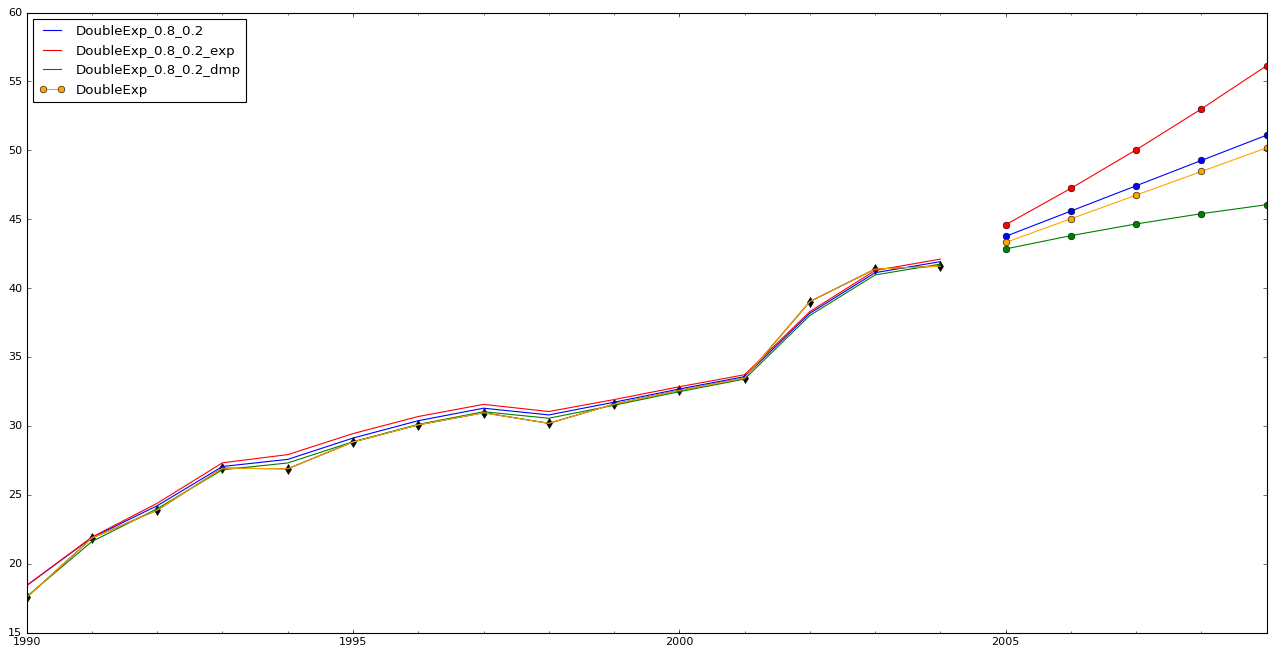

In [11]:
ax = air['Sales'].plot(color="black", marker="d", figsize=(20,10))

fit2a.level.plot(ax=ax, color='blue')
fcast2a.plot(ax=ax, color='blue', marker="o", legend=True)

fit2b.level.plot(ax=ax, color='red')
fcast2b.plot(ax=ax, color='red', marker="o", legend=True)

fit2c.level.plot(ax=ax, color='green')
fcast2c.plot(ax=ax, color='green', marker="o", legend=True)

fit2d.level.plot(ax=ax, color='orange')
fcast2d.plot(ax=ax, color='orange', marker="o", legend=True);

### Add the predictions to your original dataframe

In [12]:
# we add the predictions
air['fit2a'] = fit2a.level
air['fit2b'] = fit2b.level
air['fit2c'] = fit2c.level
air['fit2d'] = fit2d.level

# the future predictions get added this way
air = pd.concat([air, fcast2a.rename('fcast2a')], axis=1)
air = pd.concat([air, fcast2b.rename('fcast2b')], axis=1)
air = pd.concat([air, fcast2c.rename('fcast2c')], axis=1)
air = pd.concat([air, fcast2d.rename('fcast2d')], axis=1)

# make sure the column fit2a matches Table in chapter 7.2
air

Sales      fit2a      fit2b      fit2c    fit2d    fcast2a  \
1990-12-31  17.5534  18.414720  18.414720  17.611614  17.5534        NaN   
1991-12-31  21.8600  21.894453  21.929954  21.607921  21.8600        NaN   
1992-12-31  23.8866  24.206167  24.385841  23.990931  23.8866        NaN   
1993-12-31  26.9293  27.051539  27.322088  26.818677  26.9293        NaN   
1994-12-31  26.8885  27.568415  27.914829  27.308897  26.8885        NaN   
1995-12-31  28.8314  29.117324  29.440307  28.849190  28.8314        NaN   
1996-12-31  30.0751  30.376318  30.680906  30.110372  30.0751        NaN   
1997-12-31  30.9535  31.282642  31.561611  31.026142  30.9535        NaN   
1998-12-31  30.1857  30.797004  31.042442  30.555403  30.1857        NaN   
1999-12-31  31.5797  31.717268  31.909418  31.499914  31.5797        NaN   
2000-12-31  32.5776  32.677630  32.839115  32.483078  32.5776        NaN   
2001-12-31  33.4774  33.573537  33.713345  33.398057  33.4774        NaN   
2002-12-31  39.0216  38.172697  38.294475  38.012970  39.0216        NaN   
2003-12-31  41.3864  41.120193  41.280147  40.955307  41.3864        NaN   
2004-12-31  41.5966  41.920446  42.103696  41.742758  41.5966        NaN   
2005-12-31      NaN        NaN        NaN        NaN      NaN  43.757004   
2006-12-31      NaN        NaN        NaN        NaN      NaN  45.593562   
2007-12-31      NaN        NaN        NaN        NaN      NaN  47.430121   
2008-12-31      NaN        NaN        NaN        NaN      NaN  49.266679   
2009-12-31      NaN        NaN        NaN        NaN      NaN  51.103237   

              fcast2b    fcast2c    fcast2d  
1990-12-31        NaN        NaN        NaN  
1991-12-31        NaN        NaN        NaN  
1992-12-31        NaN        NaN        NaN  
1993-12-31        NaN        NaN        NaN  
1994-12-31        NaN        NaN        NaN  
1995-12-31        NaN        NaN        NaN  
1996-12-31        NaN        NaN        NaN  
1997-12-31        NaN        NaN        NaN  
1998-12-31        NaN        NaN        NaN  
1999-12-31        NaN        NaN        NaN  
2000-12-31        NaN        NaN        NaN  
2001-12-31        NaN        NaN        NaN  
2002-12-31        NaN        NaN        NaN  
2003-12-31        NaN        NaN        NaN  
2004-12-31        NaN        NaN        NaN  
2005-12-31  44.598756  42.842676  43.313971  
2006-12-31  47.241672  43.808867  45.031343  
2007-12-31  50.041208  44.657126  46.748714  
2008-12-31  53.006644  45.401849  48.466086  
2009-12-31  56.147811  46.055672  50.183457

> What were the final parameters for the four models?  

Statmodels calculates the SSE for us so that we can compare the four models and determine which one has the lowest SSE.

In [13]:
print('fit2a = ', fit2a.model.params['smoothing_level'], fit2a.model.params['smoothing_slope'], 'errors = ', fit2a.sse)
print('fit2b = ', fit2b.model.params['smoothing_level'], fit2b.model.params['smoothing_slope'], 'errors = ', fit2b.sse)
print('fit2c = ', fit2c.model.params['smoothing_level'], fit2c.model.params['smoothing_slope'], 'errors = ', fit2c.sse)
print('fit2d = ', fit2d.model.params['smoothing_level'], fit2d.model.params['smoothing_slope'], 'errors = ', fit2d.sse)

fit2a =  0.8 0.2 errors =  72.7868152835
fit2b =  0.8 0.2 errors =  126.878388677
fit2c =  0.8 0.2 errors =  41.4110035576
fit2d =  1.0 0.0 errors =  37.4285449886


# Residuals

The *residuals* in a time series model are what is left over after fitting a model. For many (but not all) time series models, the residuals are equal to the difference between the observations and the corresponding fitted values. Residuals are useful in checking whether a model has adequately captured the information in the data. 

### A good forecasting method will yield residuals with the following properties:

* The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.

* The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

Any forecasting method that does not satisfy these properties can be improved. However, that does not mean that forecasting methods that satisfy these properties cannot be improved. It is possible to have several different forecasting methods for the same data set, all of which satisfy these properties. Checking these properties is important in order to see whether a method is using all of the available information, but it is not a good way to select a forecasting method.

If either of these properties is not satisfied, then the forecasting method can be modified to give better forecasts. Adjusting for bias is easy: 

* If the residuals have mean m, then simply add m to all forecasts and the bias problem is solved. 
* Fixing the correlation problem is harder, and we will not address it until [Chapter 9](https://www.otexts.org/fpp/9).

In addition to these essential properties, it is useful (but not necessary) for the residuals to also have the following two properties.

* The residuals have constant variance
* The residuals are normally distributed  

These two properties make the calculation of prediction intervals easier (see Section 3.5 for an example). However, a forecasting method that does not satisfy these properties cannot necessarily be improved. Sometimes applying a Box-Cox transformation may assist with these properties, but otherwise there is usually little that you can do to ensure that your residuals have constant variance and a normal distribution. Instead, an alternative approach to obtaining prediction intervals is necessary. Again, we will not address how to do this until later in the book.

> We will use fit2c to calculate the residuals. I will explain later why I did not choose fit2d

In [14]:
# we remove null values to prevent any issues
res = air['Sales'].dropna() - air['fit2c'].dropna()

We can see that around the year 2002, something must have happended and we can see a bump on that year. We can also see from the bottom two charts that the data is not normal. This just means we will not be able to create confidence bands on the residuals. The lag plot tells us that the residuals are random.   

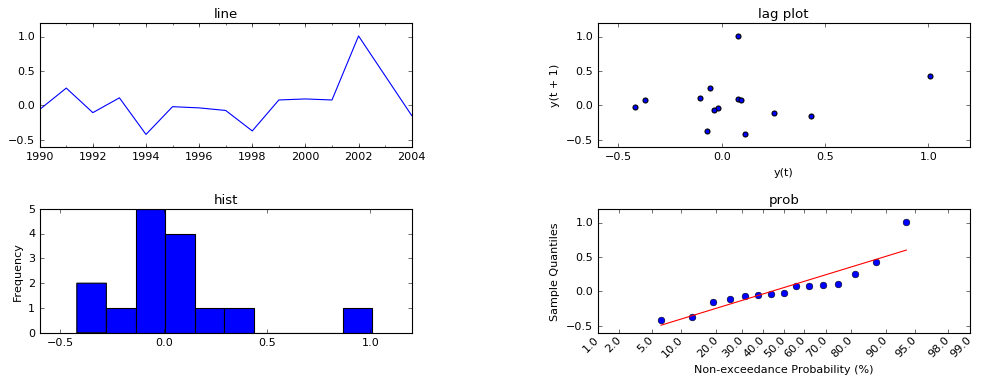

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2)
plt.subplots_adjust(wspace=0.5, hspace=0.5);

res.plot(ax=axes[0,0], figsize=(15,5)); axes[0,0].set_title('line');
lag_plot(res, ax=axes[0,1]); axes[0,1].set_title('lag plot');
res.plot.hist(ax=axes[1,0], figsize=(15,5)); axes[1,0].set_title('hist');
sm.ProbPlot(res).probplot(line='r',ax=axes[1,1]); axes[1,1].set_title('prob');

> The ACP confirms that the residuals have no other hidden patterns we can make use of  

Since our ac plot is within the confidence bands, our model has no other patterns in the data to work with. While this does not mean you cannot improve the model, it does mean your model should give you good results. 

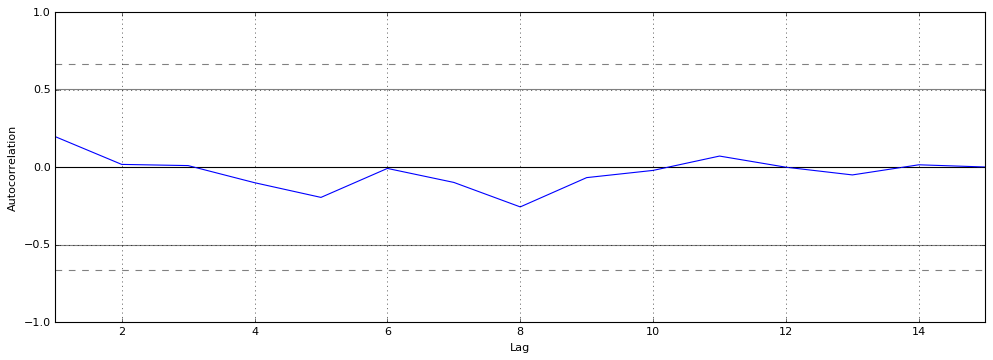

In [16]:
plt.figure(figsize=(15, 5))
autocorrelation_plot(res);

> The mean and the median both are close to zero. This confirms our predictions are not biased.

If a biased existed, you would simply add the amount of the median to all of your predictions. 

In [17]:
res.describe()

count    15.000000
mean      0.055438
std       0.339152
min      -0.420397
25%      -0.088486
50%      -0.017790
75%       0.102573
max       1.008630
dtype: float64

### Why did I choose not to use the model with the lowest error, fit2d?  

The predictions for fit2d were soo good that they almost match our original data set. This is probably a sign that this model is overfitting our data and may not perform well on data it has not seen. In addition, if we try to plot the residuals you will see the lag plot and the other 3 plots will look weird. I also wanted to avoid that situation for this tutorial. 

> Please try using the fit2d model instead of the fit2c model and see what the plots look like. 

# Your Turn

Go to [Example 7.3 Sheep in Asia](https://www.otexts.org/fpp/7/4) and try to work on the ***livestock2*** data set. 

<p class="text-muted">This tutorial was created by <a href="http://www.hedaro.com" target="_blank"><strong>HEDARO</strong></a></p>